# **DEPENDENCIES**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

In [2]:
from google.colab import drive; drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DATASET**

In [3]:
def create_dataset(faces_dataset_path):
    train_images = []
    train_labels = []
    val_images = []
    val_labels = []
    test_images = []
    test_labels = []

    class_labels = os.listdir(faces_dataset_path)
    num_classes = len(class_labels)

    for class_idx, folder in enumerate(tqdm(class_labels)):
        folder_path = os.path.join(faces_dataset_path, folder)
        images = os.listdir(folder_path)
        np.random.shuffle(images)
        num_images = len(images)

        for i, file in enumerate(images):
            img = cv2.imread(os.path.join(folder_path, file))
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            if i < 0.7 * num_images:
                train_images.append(img)
                train_labels.append(class_idx)
            elif i < 0.85 * num_images:
                val_images.append(img)
                val_labels.append(class_idx)
            else:
                test_images.append(img)
                test_labels.append(class_idx)

    return (
        np.array(train_images), np.array(train_labels),
        np.array(val_images), np.array(val_labels),
        np.array(test_images), np.array(test_labels)
    )

### **Human Dataset**   
Description: 9 different people. 128 x 128 images

In [4]:
faces_dataset_path = "/content/drive/MyDrive/data_assn2_cv/actors/images"
Xtrf, Ytrf, Xvaf, Yvaf, Xtef, Ytef = create_dataset(faces_dataset_path)

100%|██████████| 8/8 [00:12<00:00,  1.62s/it]


### **Cifar10 Dataset**  
Description:
1. Using Cifar10 for non-human objects. These images are 32 x 32, but it won't be a problem since the histograms will be normalized.
2. For grayscaling, I use the formula $Gr = 0.3R + 0.59G + 0.11B$ as per the following blog (Did this to avoid using cv2 loops):  
[Colour to Grayscale](https://www.baeldung.com/cs/convert-rgb-to-grayscale)

In [5]:
(Xtrc, Ytrc), (Xtec, Ytec) = tf.keras.datasets.cifar10.load_data()
Xtrc = np.dot(Xtrc, [0.3, 0.59, 0.11]).astype(int)
Xtec = np.dot(Xtec, [0.3, 0.59, 0.11]).astype(int)

# **HOG**  
### Histogram of Oriented Gradients (HOG) Computation

The `compute_hog` function takes an input grayscale image, `cell_size`, `block_size`, and `num_bins`. It calculates HOG feature vectors by analyzing the local gradient information within the image. Default is num_bin=255

### Formula

For each cell in the image:

- Calculate gradients in the x and y directions using Sobel operators.
- Calculate the magnitude and direction of gradients.
- Define the number of cells in the x and y directions.
- Create a histogram for each cell, quantizing gradient directions into bins.
- Combine histograms into HOG feature vectors for the entire image.

### Output

The output is an array of HOG feature vectors representing the image, with each vector encoding local gradient information for a specific region of the image.

In [6]:
def compute_oriented_gradients(images, axis=0):
    if axis not in [0, 1]:
        raise ValueError(
            "Axis must be 0 or 1 for row-wise or column-wise processing."
        )

    num_images, height, width = images.shape
    og_images = np.zeros(images.shape, dtype=np.float32)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if axis == 0:
                gradient_x = images[:, i, j + 1] - images[:, i, j - 1]
                gradient_y = images[:, i + 1, j] - images[:, i - 1, j]
            else:
                gradient_x = images[i, j + 1, :] - images[i, j - 1, :]
                gradient_y = images[i + 1, j, :] - images[i - 1, j, :]

            orientation = np.arctan2(gradient_y, gradient_x)
            og_images[:, i, j] = orientation

    return og_images

In [7]:
def plot_oriented_gradients(original_images, cells_per_block=(2, 2), bins=255//4):
    num_images = len(original_images)
    og_images = compute_oriented_gradients(original_images)
    hogs = compute_hog(og_images, cells_per_block=cells_per_block, bins=bins)

    fig, axs = plt.subplots(3, num_images, figsize=(3 * num_images, 9))
    plt.tight_layout(pad=0.0)

    for i in range(num_images):
        axs[0, i].imshow(original_images[i], cmap='gray')
        axs[0, i].set_title('Original')
        axs[0, i].axis('off')


        axs[1, i].imshow(og_images[i], cmap='hsv', vmin=-np.pi, vmax=np.pi)
        axs[1, i].set_title('OG')
        axs[1, i].axis('off')


        axs[2, i].plot(hogs[i])
        axs[2, i].set_title('HOG')

    plt.show()

### Plot of Original vs OG images

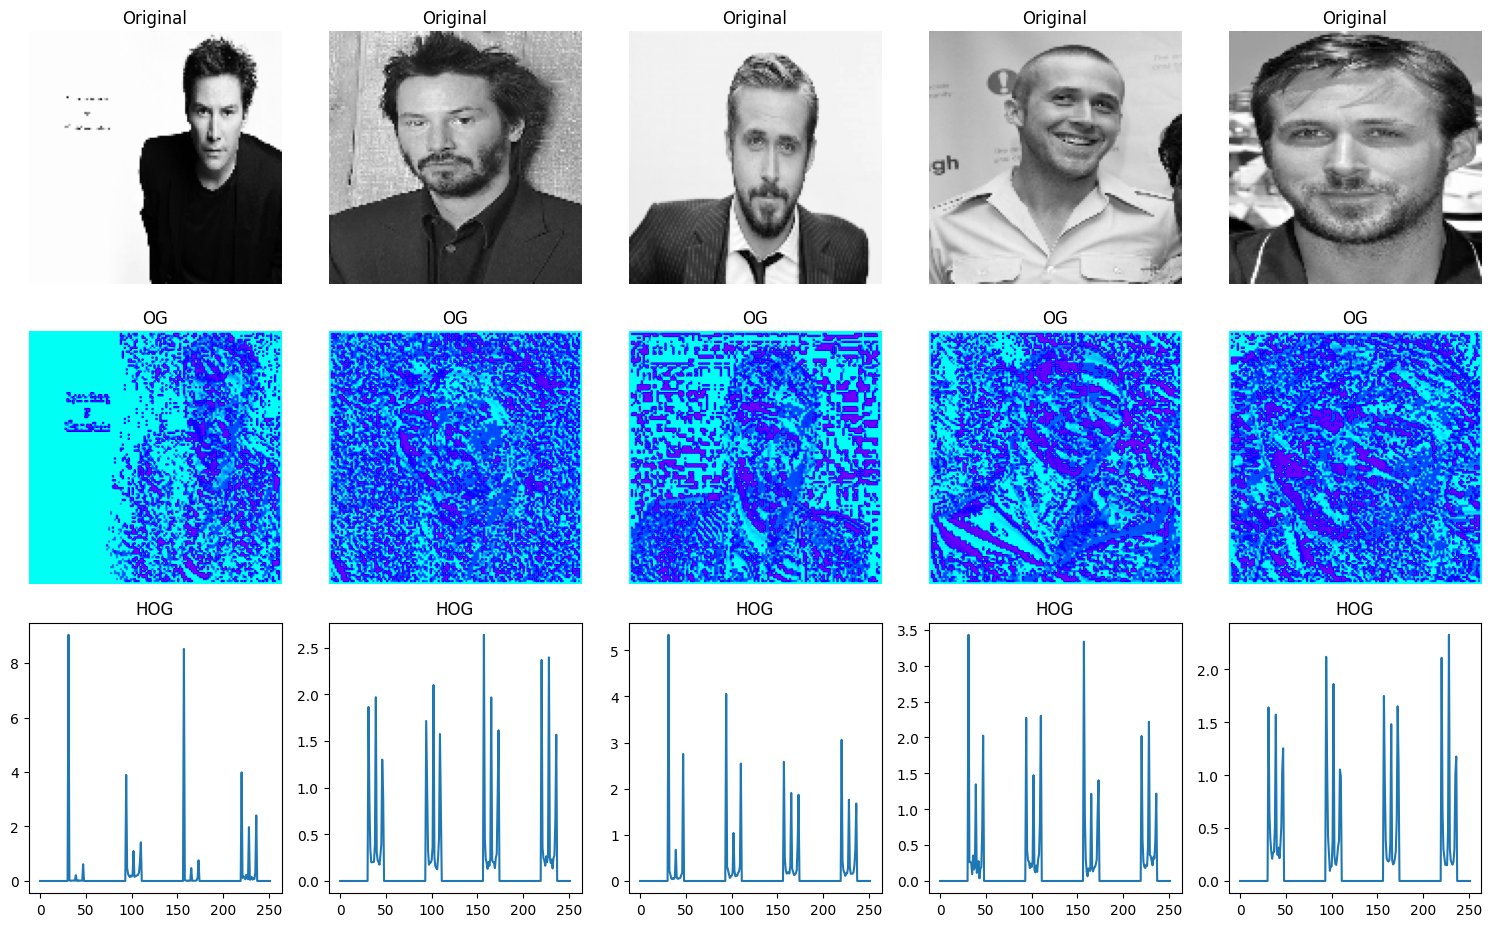

In [58]:
S = Xtrf[np.random.randint(0, Xtrf.shape[0], 5)]; plot_oriented_gradients(S)

## Compute Histograms of OG
### Explanation

The `compute_hog` function is designed to compute Histogram of Oriented Gradients (HOG) features from a set of oriented gradient images.

1. **Function Signature:**
    ```python
    def compute_hog(og_images, cells_per_block=(2, 2), bins=255):
    ```
    - `og_images`: A NumPy array containing oriented gradient images.
    - `cells_per_block`: The number of cells per block for HOG computation.
    - `bins`: The number of bins in the histogram for the HOG feature.

2. **Initialization:**
    ```python
    num_images, height, width = og_images.shape
    cell_height = height // cells_per_block[0]
    cell_width = width // cells_per_block[1]
    hog_features = []
    ```

3. **Loop Over Images:**
    ```python
    for image in og_images:
    ```

4. **Initialize Image-Level HOG Histogram:**
    ```python
    image_hog = np.zeros((cells_per_block[0], cells_per_block[1], bins))
    ```

5. **Loop Over Cells:**
    ```python
    for i in range(cells_per_block[0]):
        for j in range(cells_per_block[1]):
    ```

6. **Compute Cell Histogram:**
    ```python
    cell = image[i * cell_height: (i + 1) * cell_height, j * cell_width: (j + 1) * cell_width]
    cell_hist, _ = np.histogram(cell, bins=bins, range=(-np.pi, np.pi), density=True)
    ```

7. **Store Cell Histogram in `image_hog`:**
    ```python
    image_hog[i, j, :] = cell_hist
    ```

8. **Flatten and Append Image-Level HOG Feature:**
    ```python
    hog_features.append(image_hog.ravel())
    ```

9. **Return HOG Features:**
    ```python
    hog_features = np.array(hog_features)
    return hog_features
    ```



In [8]:
def compute_hog(og_images, cells_per_block=(2, 2), bins=255//4):
    num_images, height, width = og_images.shape
    cell_height = height // cells_per_block[0]
    cell_width = width // cells_per_block[1]

    hog_features = []

    for image in og_images:
        image_hog = np.zeros((cells_per_block[0], cells_per_block[1], bins))

        for i in range(cells_per_block[0]):
            for j in range(cells_per_block[1]):
                cell = image[i * cell_height: (i + 1) * cell_height, j * cell_width: (j + 1) * cell_width]
                cell_hist, _ = np.histogram(cell, bins=bins, range=(-np.pi, np.pi), density=True)
                image_hog[i, j, :] = cell_hist

        hog_features.append(image_hog.ravel())

    hog_features = np.array(hog_features)

    return hog_features

In [9]:
Xtrfh = compute_hog(compute_oriented_gradients(Xtrf))
Xtefh = compute_hog(compute_oriented_gradients(Xtef))
Xvafh = compute_hog(compute_oriented_gradients(Xvaf))

# **KNN**

In [10]:
class KNNClassifier():
    def __init__(self, K, metric='euclidean'):
        self.K = K
        self.metric = metric
        self.inv_mcm = None

    @staticmethod
    def mode(arr):
        unique, counts = np.unique(arr, return_counts=True)
        return unique[np.argmax(counts)]

    def euclidean_distance(self, x):
        return np.sqrt(np.sum((self.X - x) ** 2, axis=1))

    def manhattan_distance(self, x):
        return np.sum(np.abs(self.X - x), axis=1)

    def chebyshev_distance(self, x):
        return np.max(np.abs(self.X - x), axis=1)

    def mahalanobis_distance(self, x):
        if self.inv_mcm is None:
            raise ValueError("Covariance matrix is not available.")
        diff = self.X - x
        distances = np.sqrt(np.sum(np.dot(diff, self.inv_mcm) * diff, axis=1))
        return distances

    def minkowski_distance(self, x, p=2):
        return np.power(np.sum(np.power(np.abs(self.X - x), p), axis=-1), 1/p)

    def cosine_distance(self, x):
        dot_product = np.dot(self.X, x)
        norm_x = np.linalg.norm(x)
        norm_data = np.linalg.norm(self.X, axis=1)
        cosine_sim = dot_product / (norm_x * norm_data)
        cosine_distance = 1 - cosine_sim
        return cosine_distance

    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.m, self.n = X.shape

        if self.metric == 'mahalanobis':
            mah_covariance_matrix = np.cov(X, rowvar=False, bias=True)
            self.inv_mcm = np.linalg.pinv(mah_covariance_matrix)

    def predict(self, X):
        self.X_test = X
        self.m_test, _ = X.shape
        Y_predict = np.zeros(self.m_test)

        for i in range(self.m_test):
            x = X[i]
            neighbors = self.find_neighbors(x)
            Y_predict[i] = self.mode(neighbors)

        return Y_predict

    def find_neighbors(self, x):
        if self.metric == 'mahalanobis':
            distances = self.mahalanobis_distance(x)
        elif self.metric == 'euclidean':
            distances = self.euclidean_distance(x)
        elif self.metric == 'manhattan':
            distances = self.manhattan_distance(x)
        elif self.metric == 'chebyshev':
            distances = self.chebyshev_distance(x)
        elif self.metric == 'minkowski':
            distances = self.minkowski_distance(x)
        elif self.metric == 'cosine':
            distances = self.cosine_distance(x)

        inds = distances.argsort()
        Y_sorted = self.Y[inds]
        return Y_sorted[:self.K]

    def score(self, X_test, Y_true):
        Y_pred = self.predict(X_test)
        accuracy = np.mean(Y_pred == Y_true)
        return accuracy

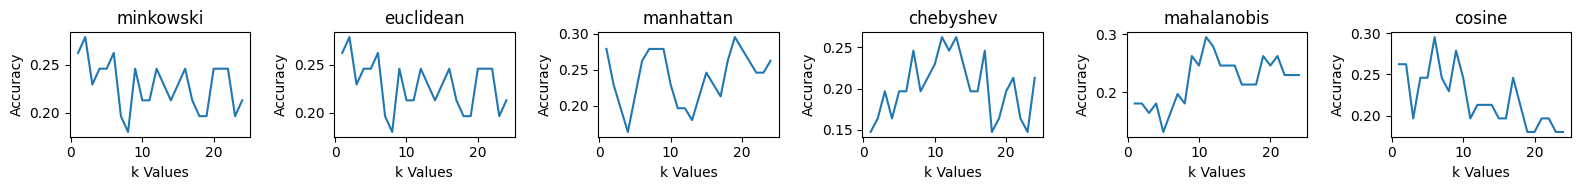

Best KNN model on validation data: K=19, metric-manhattan: Score (Val acc)=0.29508196721311475
Accuracy on train data: 0.3896551724137931
Accuracy on val data: 0.29508196721311475
Accuracy on test data: 0.1864406779661017


In [11]:
k_values = range(1, 25)
distance_metrics = ['minkowski', 'euclidean', 'manhattan', 'chebyshev', 'mahalanobis', 'cosine']
best_model = None
best_score = 0
fig, axes = plt.subplots(1, 6, figsize=(16, 2))
for j, distance_metric in enumerate(distance_metrics):
    accuracy_values = []
    for k in k_values:
        knn = KNNClassifier(k, metric=distance_metric)
        knn.fit(Xtrfh, Ytrf)
        accuracy = knn.score(Xvafh, Yvaf)
        if accuracy > best_score:
            best_model = knn
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[j]
    ax.plot(k_values, accuracy_values)
    ax.set_xlabel('k Values')
    ax.set_ylabel('Accuracy')
    ax.set_title(distance_metric)
plt.tight_layout()
plt.show()
print(f"Best KNN model on validation data: K={best_model.K}, metric-{best_model.metric}: Score (Val acc)={best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrfh, Ytrf)}")
print(f"Accuracy on val data: {best_model.score(Xvafh, Yvaf)}")
print(f"Accuracy on test data: {best_model.score(Xtefh, Ytef)}")

Surprisingly, manhattan distance proves to be the most successful.

# **SVM**

In [12]:
from sklearn import svm

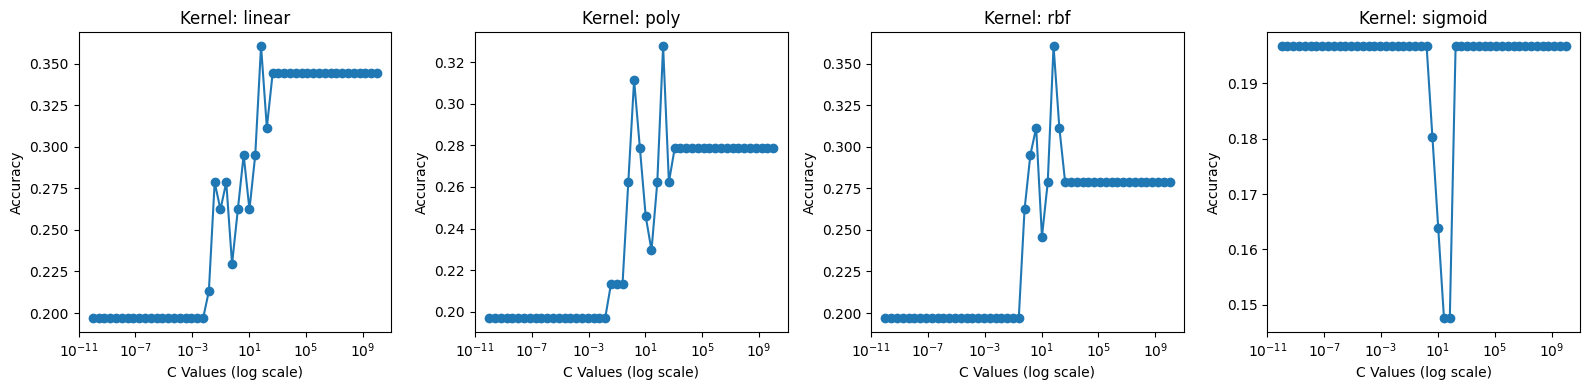

Best SVM model on validation data: C=68.66488450042998, kernel-linear | Accuracy = 0.36065573770491804
Accuracy on train data: 0.9482758620689655
Accuracy on val data: 0.36065573770491804
Accuracy on test data: 0.3389830508474576


In [13]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = np.logspace(-10, 10, 50)
degree = np.arange(10)
best_model = None
best_score = 0

fig, axes = plt.subplots(1, len(kernels), figsize=(16, 4))

for i, kernel in enumerate(kernels):
    accuracy_values = []
    for C in C_values:
        svm_classifier = svm.SVC(kernel=kernel, C=C, decision_function_shape='ovr')
        svm_classifier.fit(Xtrfh, Ytrf)
        accuracy = svm_classifier.score(Xvafh, Yvaf)
        if accuracy > best_score:
            best_model = svm_classifier
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[i]
    ax.plot(C_values, accuracy_values, marker='o')
    ax.set_xscale('log')
    ax.set_xlabel('C Values (log scale)')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Kernel: {kernel}')
plt.tight_layout()
plt.show()
print(f"Best SVM model on validation data: C={best_model.C}, kernel-{best_model.kernel} | Accuracy = {best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrfh, Ytrf)}")
print(f"Accuracy on val data: {best_model.score(Xvafh, Yvaf)}")
print(f"Accuracy on test data: {best_model.score(Xtefh, Ytef)}")

SVM better fits the train and validation data.

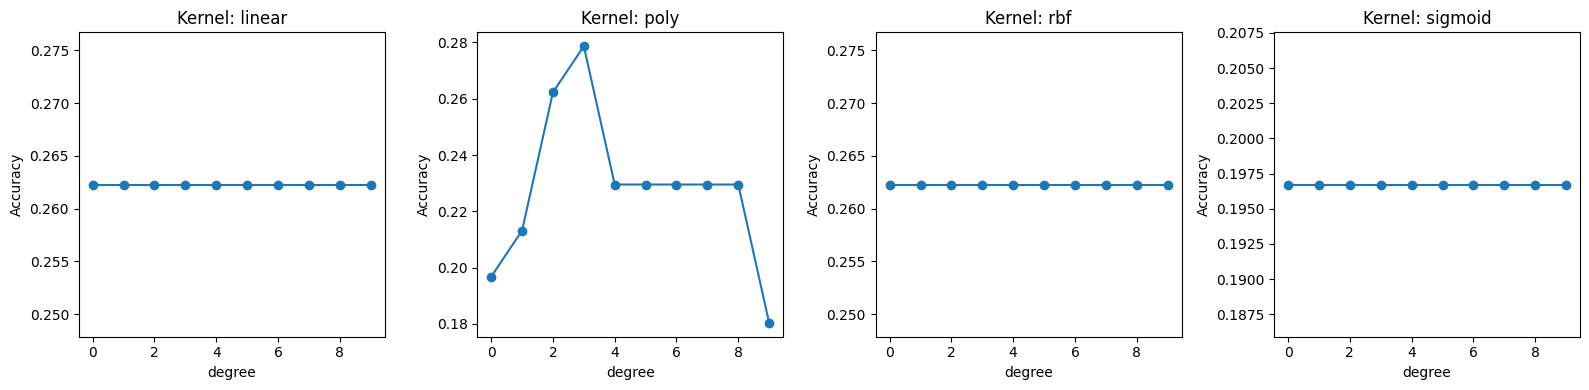

Best SVM model on validation data: d=3, kernel-poly | Accuracy = 0.2786885245901639
Accuracy on train data: 0.35172413793103446
Accuracy on val data: 0.2786885245901639
Accuracy on test data: 0.2542372881355932


In [17]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = np.arange(10)
best_model = None
best_score = 0

fig, axes = plt.subplots(1, len(kernels), figsize=(16, 4))

for i, kernel in enumerate(kernels):
    accuracy_values = []
    for d in degrees:
        svm_classifier = svm.SVC(kernel=kernel, degree=d, decision_function_shape='ovr')
        svm_classifier.fit(Xtrfh, Ytrf)
        accuracy = svm_classifier.score(Xvafh, Yvaf)
        if accuracy > best_score:
            best_model = svm_classifier
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[i]
    ax.plot(degrees, accuracy_values, marker='o')
    ax.set_xlabel('degree')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Kernel: {kernel}')
plt.tight_layout()
plt.show()
print(f"Best SVM model on validation data: d={best_model.degree}, kernel-{best_model.kernel} | Accuracy = {best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrfh, Ytrf)}")
print(f"Accuracy on val data: {best_model.score(Xvafh, Yvaf)}")
print(f"Accuracy on test data: {best_model.score(Xtefh, Ytef)}")

3rd degree polynomial was best for SVM polynomial kernel

## **Human Vs Non-Human**

In [18]:
Xtrc = Xtrc[: Xtrf.shape[0]]
Xtec = Xtec[: Xtef.shape[0]]
Ytrc = Ytrc[: Ytrf.shape[0]]
Ytec = Ytec[: Ytef.shape[0]]

In [19]:
Xtrch = compute_hog(compute_oriented_gradients(Xtrc))
Xtech = compute_hog(compute_oriented_gradients(Xtec))

In [20]:
Xtr_combined = np.concatenate((Xtrfh, Xtrch), axis=0)
Ytr_combined = np.zeros(Xtr_combined.shape[0])
Ytr_combined[: Xtr_combined.shape[0] // 2] = 1
Xte_combined = np.concatenate((Xtefh, Xtech), axis=0)
Yte_combined = np.zeros(Xte_combined.shape[0])
Yte_combined[:Xte_combined.shape[0] // 2] = 1

In [21]:
svm_classifier = svm.SVC(kernel='linear', C=1.0)
svm_classifier.fit(Xtr_combined, Ytr_combined)
Yte_pred = svm_classifier.predict(Xte_combined)
accuracy = svm_classifier.score(Xte_combined, Yte_combined)
print("Test accuracy:", accuracy)

Test accuracy: 1.0


The face vs no-face classification accuracy on test set is: 0.72

# **SLIDING WINDOW FACE DETECTION**

In [22]:
from skimage.transform import resize

In [23]:
selected_images_f = Xtrf[:2]
selected_images_c = (resize(Xtrc[:2], (2, 128, 128)))
selected_images_c = (selected_images_c - selected_images_c.min()) * 255 / (selected_images_c.max() - selected_images_c.min())
combined_image = np.zeros((4 * 128, 128))
combined_image[: 2 * 128, :] = selected_images_f.reshape(-1, 128)
combined_image[2 * 128: , :] = selected_images_c.reshape(-1, 128)
combined_image = combined_image.astype(np.uint8)

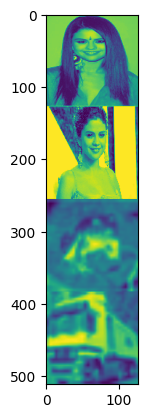

In [24]:
plt.imshow(combined_image)

In [25]:
image = combined_image
shape = image.shape
image = compute_oriented_gradients(image.reshape(1, *shape))
swv = np.lib.stride_tricks.sliding_window_view(image[0], (80, 80), axis=[0, 1])
swv = swv.reshape(-1, *(80, 80))
his = compute_hog(swv)

In [35]:
pred = svm_classifier.predict(his)
pred = pred.reshape(shape[0] - 79, shape[1] - 79)

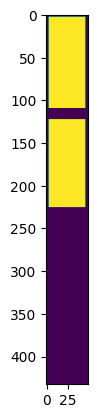

In [34]:
plt.imshow(pred)

As it can be seen, the region of the faces is being detected as 1. The histograms were being computed from 80 x 80 chunks.